VAEs dynamiques : https://arxiv.org/abs/2008.12595

# Training a Variational RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from libs.vrnn_lib_sprites import seed_everything, VRNN
from libs.vrnn_lib_sprites import loss_function, train
from libs.vrnn_lib_sprites import BetaLinearScheduler, BetaThresholdScheduler
from libs.vrnn_lib_sprites import plot_losses, sample_predictions

In [3]:
# Set seed for reproducibility
seed_everything(42)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


# Modèle

### Variational RNN :

The full factorization of $p(z_{1:T}, x_{1:T})$ is used:

\begin{align}
p(z_{1:T}, x_{1:T}) &= \prod_{t=1}^T p(z_t, x_t \vert z_{1:t-1}, x_{1:t-1}) \\
&= \prod_{t=1}^T p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t}) p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1}) \\
\end{align}

Where the two distributions $p_{\theta_z}$ and $p_{\theta_x}$ are Gaussians :

\begin{align}

p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t}) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}), \text{diag}(\sigma_{\theta_x}^{2}(\overrightarrow{g}_{t-1}, h_{t}))) \\
d_x(\overrightarrow{g}_{t-1}, h_{t}) &= [ \mu_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}), \sigma_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}) ] \\

p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(\overrightarrow{g}_{t-1}, h_{t-1}))) \\
d_z(\overrightarrow{g}_{t-1}, h_{t-1}) &= [ \mu_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}), \sigma_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}) ] \\

\end{align}

où $d_x, d_z$ sont des MLP,

et où $h_t = \text{LSTM}(z_t, h_{t-1})$ est un forward LSTM qui encode $z_{1:t}$

et $\overrightarrow{g}_t = \text{LSTM}(x_t, \overrightarrow{g}_{t-1})$ est un forward LSTM qui encode $x_{1:t}$

### Modèle inférence

Le "true posterior" s'écrit :
\begin{align}
p_{\theta}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T p_{\theta} (z_t \vert z_{1:t-1}, x_{1:T} ) \\
\end{align}

où la première écriture est la stricte application de la chain rule.

On choisit comme approximation du posterior (=encodeur) une formulation calquée sur le vrai posterior :

\begin{align}
q_{\phi}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T q_{\phi} (z_{t} \vert z_{1:t-1}, x_{1:T}) \\
\end{align}

Et:
\begin{align}
q_{\phi} (z_{t} \vert z_{1:t-1}, x_{1:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}), \text{diag} (\sigma_{\phi}^2(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}))) \\
d_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}) &= [ \mu_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}), \sigma_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}) ]
\end{align}

où $d_{\phi}$ est un MLP, et

$\overleftarrow{g}_t = \text{LSTM}(x_t, \overleftarrow{g}_{t-1})$ est un backward LSTM qui encode $x_{t:T}$

# Implémentation de l'inférence

Il y a ici quelques choix d'implémentations différents de ceux du papier originel, et adapté au dataset **Sprites** :

- **trois** LSTMs distincts pour encoder $z_{1:t}$, $x_{1:t}$ et $x_{t:T}$

- CNN3D pour Encoder et Decoder

# Training

Le modèle s'entraîne en maximisant un ELBO, dont la formulation dans le cas du VRNN est:

\begin{align}
    \begin{split}
    \mathcal{L}(\theta, \phi; X) &= \sum_{t=1}^T  \mathbb{E}{q_{\phi}(z_{1:t} \vert x_{1:T})} \log{p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t})} \\ &- \sum_{t=1}^T \mathbb{E}{q_{\phi}(z_{1:t-1} \vert x_{1:T})} \mathbb{KL}{q_{\phi}(z_t \vert z_{1:t-1}, x_{1:T})}{p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1})} 
    \end{split}    
\end{align}
<!-- 
Les deux termes s'explicitent de la façon suivante (avec $D$ dimension de l'espace des observations) :

\begin{align}
p_{\theta_x}(x_t \vert z_t) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(z_t), \text{diag}(\sigma_{\theta_x}^2(z_t))) \\
\log{p_{\theta_x}(x_t \vert z_t)} &= -\frac{D}{2} \log{2\pi} - \frac{1}{2}\log{\vert \text{diag}(\sigma_{\theta_x}^2(z_t)) \vert} - 
\frac{1}{2} \left[ (x_t - \mu_{\theta_x}(z_t))^T (\text{diag}(\sigma_{\theta_x}^2(z_t)))^{-1} (x_t - \mu_{\theta_x}(z_t)) \right] \\
&= - \frac{1}{2} \left( \sum_{i=1}^D \log{\sigma_{\theta_x}^2(z_t)}\vert_{i} + (x_t - \mu_{\theta_x}(z_t))^T \text{diag} \frac{1}{\sigma_{\theta_x}^2(z_t)} (x_t - \mu_{\theta_x}(z_t)) + D \log{2\pi} \right)
\end{align}

Et la KL entre les deux Gaussiennes:

\begin{align}
q_\phi(z_t \vert z_{t-1}, x_{t:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(g_t), \text{diag}(\sigma_\phi^2(g_t))) \\
p_{\theta_z}(z_t \vert z_{t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(z_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(z_{t-1}))) \\
\end{align}

a une close form (avec $Z$ dimension de l'espace latent):

\begin{align}
\text{D}_{\text{KL}}(q_\phi \vert\vert p_{\theta_z}) &= \frac{1}{2} \left[ \text{Tr}(\text{diag}(\sigma_{\theta_z}^{2})^{-1} \text{diag}(\sigma_\phi^2) ) + (\mu_{\theta_z} - \mu_\phi)^T (\text{diag}(\sigma_{\theta_z}^{2})^{-1}) (\mu_{\theta_z} - \mu_\phi) +
\log{\frac{\vert \text{diag}(\sigma_{\theta_z}^{2})\vert}{\vert \text{diag}(\sigma_\phi^2) \vert} } \right] \\
&= \frac{1}{2}\left[ \sum_{i=1}^Z \log{\sigma_{\theta_z}^{2}}\vert_i - \sum_{i=1}^Z \log{\sigma_{\phi}^{2}}\vert_i +
 (\mu_{\theta_z} - \mu_\phi)^T \text{diag}(\frac{1}{\sigma_{\theta_z}^{2}}) (\mu_{\theta_z} - \mu_\phi) + \sum_{i=1}^Z \frac{\sigma_{\phi}^{2}\vert_i} {\sigma_{\theta_z}^{2}\vert_i} - Z 
\right]
\end{align} -->

# Data

Dataset **Sprites** : https://arxiv.org/abs/1803.02991

Characters with 6 attributes (skin color, tops, pants and hairstyle), each taking 4 possibles values : $6**4 = 1296$ possibilities.

Performing 3 possibles actions (walking, casting spells and slashing) each with 3 possible view angles : 9 actions.

Total is 1296 x 9 = 11664 : 1000 for training, 296 for test.

In [6]:
from libs.load_sprites import sprites_act
import imageio.v2 as imageio

In [10]:
X_train, X_test, A_train, A_test, D_train, D_test = sprites_act('data/sprites/', return_labels=True)

walk front 0 0 0
walk left 0 1 1
walk right 0 2 2
spellcard front 1 0 3
spellcard left 1 1 4
spellcard right 1 2 5
slash front 2 0 6
slash left 2 1 7
slash right 2 2 8
(2664, 8, 4, 6) (2664, 8, 9) (2664, 8, 64, 64, 3) shapes
(9000, 8, 64, 64, 3) 0.0 0.99609375
data loaded in 22.76 seconds...


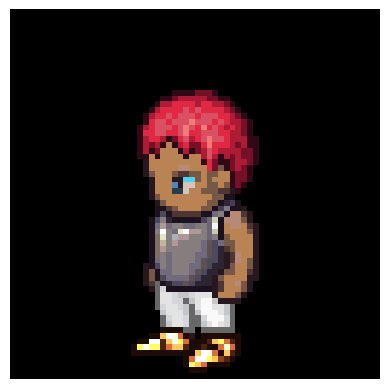

In [11]:
e = X_train[0,0,:]

plt.imshow(e)
plt.axis('off')
plt.show()

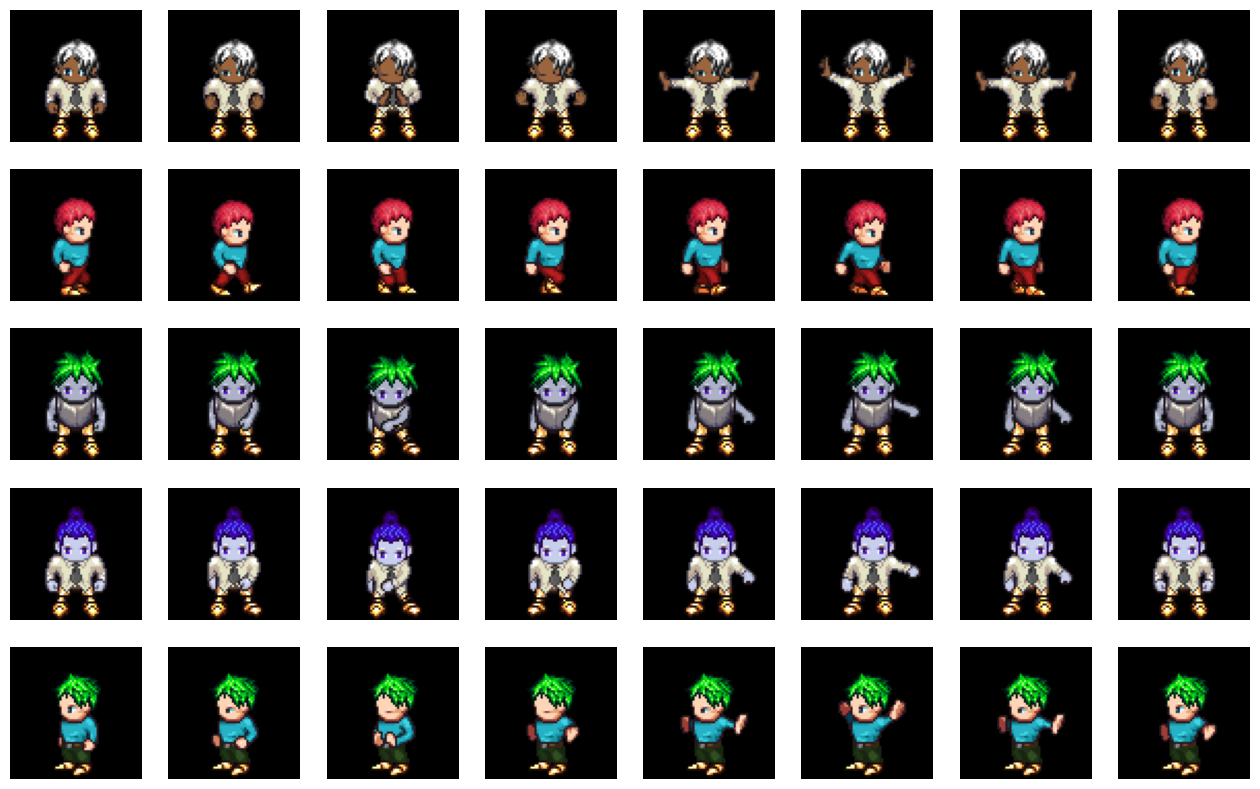

In [13]:
N = X_train.shape[0]
T = X_train.shape[1]
N_SAMPLES = 5

idx = np.random.choice(N, N_SAMPLES, replace=False)

fig, ax = plt.subplots(nrows=N_SAMPLES, ncols=T, figsize=(T*2, N_SAMPLES*2))

for i, id_seq in enumerate(idx):
    images = X_train[id_seq]
    for t in range(T):
        ax[i, t].imshow(images[t])
        ax[i, t].axis('off')

# Parameters

In [5]:
X_DIM = 1 # Dimension of the observation space
Z_DIM = 32 # Dimension of the latent space
RNN_X_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for observations
RNN_Z_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for latent variables

In [21]:
vrnn = VRNN(
    input_dim = X_DIM,
    latent_dim = Z_DIM,
    rnn_x_hidden_dim = RNN_X_H_DIM,
    rnn_z_hidden_dim = RNN_Z_H_DIM,
    device=device
).to(device)

print(vrnn)

VRNN(observation_dim=1, latent_dim=32)
Bidirectional LSTM (input_size=1, rnn_x_hidden_size=128, num_layers=1)
Forward LSTM (input_size=32, rnn_z_hidden_size=128, num_layers=1)
Encoder MLP (z_dim=32, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=384, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=64, bias=True)
)
Latent State Transition MLP (z_dim=32, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=256, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=64, bias=True)
)
Decoder MLP (x_dim=1, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=256, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_

In [22]:
optimizer = torch.optim.Adam(vrnn.parameters(), lr=1e-3)
loss_fn = loss_function

K = 5

In [23]:
num_epochs = 250
n_displays = 250
display_frequency = int(num_epochs / n_displays)

In [24]:
beta = 1.0

# beta_scheduler = BetaLinearScheduler(
#     beta_start=1e-3,
#     beta_end=1.0,
#     epoch_start=150,
#     epoch_end=200,
#     num_epochs=None
# )

# beta_scheduler = BetaThresholdScheduler(
#     rec_loss_threshold=0.0,
#     beta_start=1e-3,
#     beta_end=1.0,
#     num_epochs=20
# )

# print(beta_scheduler)

In [25]:
rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses, betas = train(
    vrnn, 
    optimizer, 
    loss_fn, 
    num_epochs=num_epochs, 
    train_loader=train_loader, 
    test_loader=test_loader, 
    batch_size=BATCH_SIZE, 
    device=device, 
    beta=beta,
    beta_scheduler=None, 
    display_frequency=display_frequency, 
    K=K
)

Starting training...
GPU Name: NVIDIA GeForce RTX 3090
Total GPU Memory: 23.7 GB
Number of epochs: 250
Learning rate: 1.000e-03
Batch size: 16
Beta scheduler: None, beta = 1.000e+00
K = 5
Training set size: 80
Validation set size: 20
Device: cuda


Epoch     1/250 with beta = 1.00e+00 - TRAINING : Rec Loss: 3.8383e-01, KL Loss: 4.5186e-01, Total Loss: 2.3116e+00 - TEST : Rec Loss: 9.5289e-01, KL Loss: 1.0482e+00, Total Loss: 1.9967e+00
Epoch     2/250 with beta = 1.00e+00 - TRAINING : Rec Loss: 3.5875e-01, KL Loss: 3.0381e-01, Total Loss: 1.8236e+00 - TEST : Rec Loss: 8.7299e-01, KL Loss: 6.9419e-01, Total Loss: 1.5700e+00
Epoch     3/250 with beta = 1.00e+00 - TRAINING : Rec Loss: 3.0889e-01, KL Loss: 2.1761e-01, Total Loss: 1.4410e+00 - TEST : Rec Loss: 7.4823e-01, KL Loss: 5.3128e-01, Total Loss: 1.2747e+00
Epoch     4/250 with beta = 1.00e+00 - TRAINING : Rec Loss: 2.6592e-01, KL Loss: 1.4543e-01, Total Loss: 1.1569e+00 - TEST : Rec Loss: 6.5290e-01, KL Loss: 3.3272e-01, Total Loss

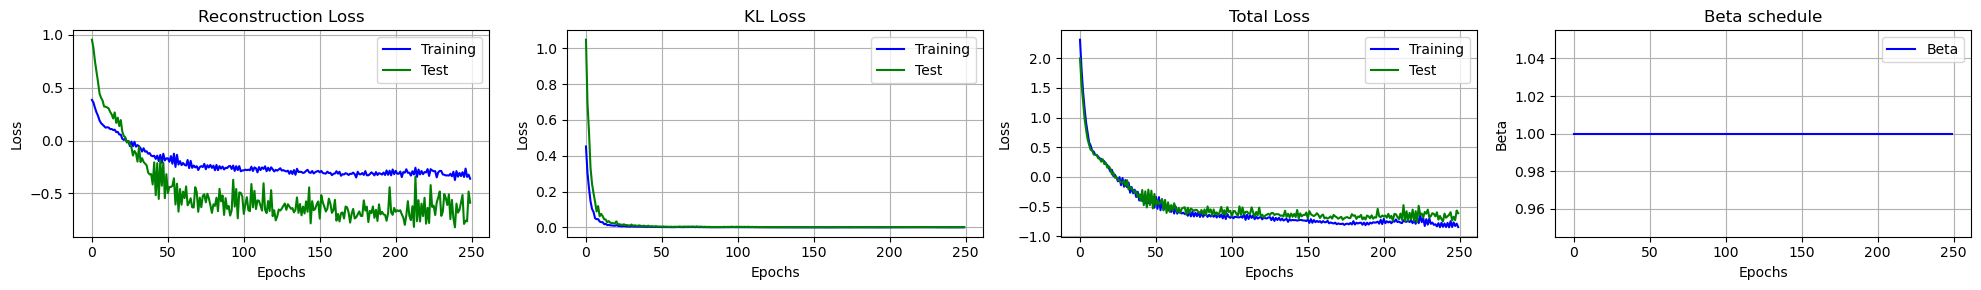

In [26]:
plot_losses(rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses, betas)

# Predictions / Générations

In [27]:
n_ahead = 10

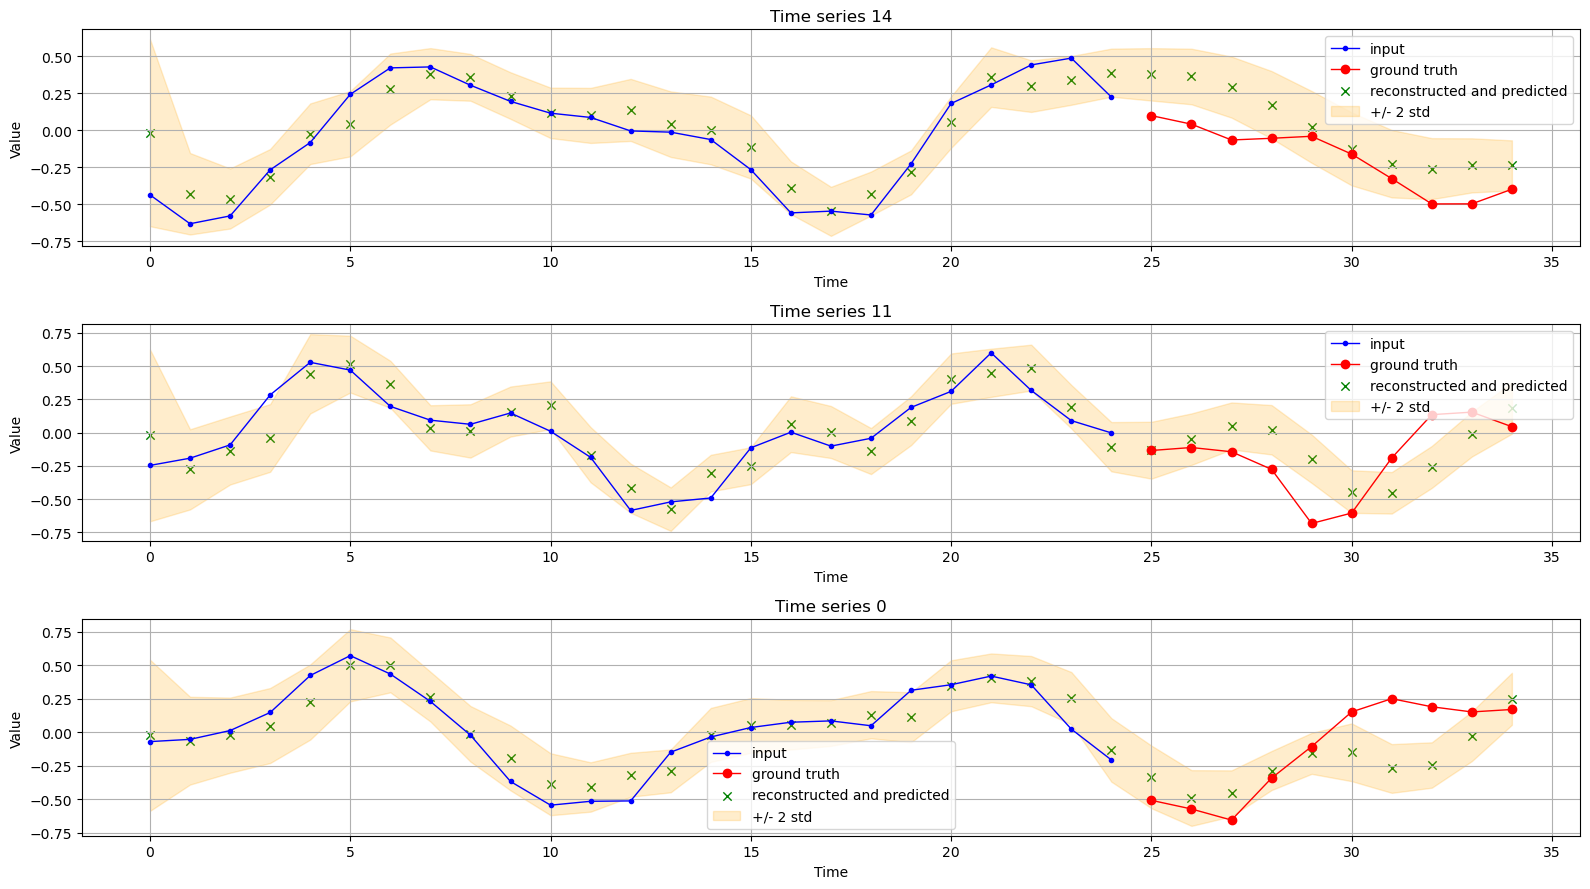

In [30]:
sample_predictions(N_SAMPLES=3, model=vrnn, X_valid=X_valid, y_valid=y_valid, n_steps=n_steps, n_ahead=n_ahead, device=device)